# Motivation

Octopath: Champions of the Continent (henceforth referred to as CotC) is a single player gatcha game where you control 8 characters of your choosing to fight tyrants, beasts, and arena champions. Basically, you are meant to save the world. Unfortunately (or fortunately depending on who you are), this game is challenging. A majority of the players struggle to clear content, primarily due to the method of balance enforced by Square Enix.

In brief: There are 8 weapon weaknesses an enemy can have, and 6 elemental weaknesses. Each character *traditionally* only carries one weapon, and *traditionally* only has access to one element. This is important because enemies take **2.5 times more damage when being hit by a weakness**. Additionally, enemies have a certain quantity of shields that will decrease if you hit their weakness (or use shield-penetrating attacks from theives). When the enemy's shield count is reduced to 0, they will take **double damage**.

This means, if you are using characters that target the enemy's weaknesses, you can do up to **5 times more damage** than if you are not.

Lastly, each and every difficult enemy in this game has a "low-health" phase, which begins when their HP is lower than a certain threshold. Once they reach this phase, their attacks will be significantly more lethal, and is the run-ender for most lost fights. This means, without the ability to quickly close off a fight, you are putting yourself at risk, which makes large amounts of damage all the more necessary.

With that in mind, I will be doing analysis on enemy weaknesses, with a particular focus on finding the optimal weapon for a character to carry.

With that said, I will be starting with

# Part 1: Data Gathering

Fortunately for me, I will not be manually entering thousands of enemies worth of data. It's completely impractical, and I cannot derive the enemies stats with manual methods.

Thankfully, a data miner by the name of BoltGSR was gracious enough to share their mined data to meowDB, a strategy website for video games. After asking for the spreadsheet from the owner of meowDB and BoltGSR, I have the sheet to all CotC enemies and their relevant data.

https://docs.google.com/spreadsheets/d/1NBLiaWwPrqtbD53-lIOZrqjI9xK9p0SQNzJKj2GrvsM/edit#gid=264844635

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 50)
pd.options.display.max_columns = None
plt.style.use('ggplot')

THIS SHEET IS RELEVANT UP TO DECEMBER 1ST, 2022. THERE WILL BE NEW ENTRIES ADDED AS TIME PROGRESSES, AND THE RESULTS OF ANALYSIS MAY HEAVILY DEVIATE DUE TO THIS.

In [2]:
main_df = pd.read_csv("Octopath English Enemy Data - v1.4.0.csv")
main_df.head()

,Id,Label,Name,DisplayLevel,Shields,StartingWeaknesses,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money
0,0,NONE,NO DATA,NaN,1,NaN,1,1,1,0,1,1,1,0,0,0,0
1,1,Forest_Enemy_01a_001,Marmot,1.0,2,"Sword, Spear, Dagger, Staff, Fire, Light",91,99,99,10,10,7,69,56,110,4,19
2,2,Forest_Enemy_01a_002,Shambling Weed,1.0,2,"Spear, Axe, Fan, Fire, Lightning, Dark",82,99,99,10,11,8,68,65,110,3,19
3,3,Forest_Enemy_01a_003,Scaled Viper,1.0,2,"Sword, Dagger, Staff, Tome, Wind, Dark",87,104,104,10,7,4,72,53,110,3,20
4,4,Forest_Enemy_01a_004,Howler,1.0,2,"Sword, Spear, Bow, Fan, Ice, Lightning",96,93,93,10,12,9,65,60,110,4,19


# Part 2: Data Management

As you can see, there are several entries that seem out of place. I will be dropping all NaNs in DisplayLevel, all NaNs in StartingWeaknesses, and I will be formatting StartingWeakness to a list in order to help with future analysis. Additionally, there are rare enemies called 'caits' that only take 1 damage and have ridiculous stats, so I'll be removing them for the sake of analysis. Additionally, there are also 'WIP' enemies with japanese names with the intent of future globalization, which I will be removing.

There is also one tutorial enemy that has 999999 HP, as well as one with 1 HP, which I will be removing.

In [3]:
df = main_df[pd.to_numeric(main_df['DisplayLevel'], errors='coerce').notnull()]
df = df[df['StartingWeaknesses'].notna()]
df = df[~df['Name'].str.contains('Cait')]
df = df[~df['Name'].str.contains('Chomper')]
df = df[~df['Name'].str.contains('Gobbler')]
df = df[~df['Name'].str.contains('Guzzler')]
df = df[~df['Label'].str.contains('tutorial_Enemy01')]
df = df[~df['Label'].str.contains('Enemy_Duel_Test')]
df = df[~df['Label'].str.contains('PV_Enemy')]
df = df[df['HP']!=999999]
df = df[df['Shields']!=99]
df = df[df['HP']!=1]
df = df[~df['Name'].str.contains('NO DATA')]
df = df[~df['Label'].str.contains('Enemy_Tower')]
df.sort_values('StartingWeaknesses').head()

,Id,Label,Name,DisplayLevel,Shields,StartingWeaknesses,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money
979,10229,ePC010_Chp4_Em02,Assassin,15.0,5,"Axe, Bow, Fan, Fire, Light",1465,190,190,29,10,10,87,108,111,63,526
867,5191,AllMASTER_Boss_Chp2_01_02,Thief,35.0,5,"Axe, Bow, Fan, Fire, Light",3200,230,230,63,45,40,150,100,180,0,0
1076,20145,ePC028_Chp3_Em02,Assassin,31.0,8,"Axe, Bow, Fan, Fire, Light",5689,357,357,57,27,27,128,139,145,2887,4084
974,10034,ePC010_Chp2_Em01,Assassin,13.0,5,"Axe, Bow, Fan, Fire, Light",1795,219,219,26,11,11,89,111,112,73,528
868,5192,AllMASTER_Boss_Chp2_01_03,Thief,35.0,5,"Axe, Bow, Fan, Fire, Light",3200,230,230,63,45,40,150,100,180,0,0


In [4]:
df['StartingWeaknesses'] = df['StartingWeaknesses'].apply(lambda x: x.replace(" ", "").split(','))

all_weaknesses = ['Sword', 'Spear', 'Dagger', 'Axe', 'Bow', 'Staff', 'Tome', 'Fan', 'Fire', 'Ice', 'Lightning', 'Wind', 'Light', 'Dark']

In [5]:
df.sort_values(by='StartingWeaknesses',ascending=True)

,Id,Label,Name,DisplayLevel,Shields,StartingWeaknesses,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money
979,10229,ePC010_Chp4_Em02,Assassin,15.0,5,"[Axe, Bow, Fan, Fire, Light]",1465,190,190,29,10,10,87,108,111,63,526
867,5191,AllMASTER_Boss_Chp2_01_02,Thief,35.0,5,"[Axe, Bow, Fan, Fire, Light]",3200,230,230,63,45,40,150,100,180,0,0
1076,20145,ePC028_Chp3_Em02,Assassin,31.0,8,"[Axe, Bow, Fan, Fire, Light]",5689,357,357,57,27,27,128,139,145,2887,4084
974,10034,ePC010_Chp2_Em01,Assassin,13.0,5,"[Axe, Bow, Fan, Fire, Light]",1795,219,219,26,11,11,89,111,112,73,528
868,5192,AllMASTER_Boss_Chp2_01_03,Thief,35.0,5,"[Axe, Bow, Fan, Fire, Light]",3200,230,230,63,45,40,150,100,180,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,2117,Snow_Enemy_01a_006,Menacing Ice Elemental,15.0,6,"[Tome, Fire, Lightning, Light]",8850,160,160,32,30,50,100,110,130,60,135
430,681,River_Enemy_09a_002,Sea Slug,62.0,6,"[Tome, Fire, Wind, Dark]",6200,610,600,144,100,95,180,210,234,1550,430
659,30251,BF_Clif_Enemy_02b_006,Menacing Lightning Elemental,45.0,10,"[Tome, Ice, Wind, Light]",31790,460,460,87,40,90,150,200,210,2000,405
557,2055,Clif_Enemy_02b_006,Menacing Lightning Elemental,45.0,10,"[Tome, Ice, Wind, Light]",31790,460,460,87,40,90,150,200,210,2000,405


With that done, we can begin one-hot encoding each weakness. I will also add a variable for the number of weaknesses the enemies carry.

In [6]:
def one_hot_helper(lis, word):
    if word in lis:
        return 1
    else:
        return 0

for weakness in all_weaknesses:
    col = 'weak'+weakness
    df[col] = df['StartingWeaknesses'].map(lambda x: one_hot_helper(x, weakness))

df['numWeaknesses'] = df['StartingWeaknesses'].map(len)

Since our ultimate goal is to predict weaknesses based on various characteristics, I will add several more columns. For example, by an enemy's sprite, I can tell if it's bipedal, sapient, unholy (you will see what I mean), amphibian, reptillian, capable of flight, a magical construct, a mammal, as well as the region it resides in.

All this information can potentially help determine which weaknesses the enemies carry, which is why I will also one-hot-encode these variables.

In [7]:
pd.set_option('display.max_rows', 1000)

df['Region'] = ''
df.loc[df['Label'].str.contains('Snow_'), 'Region'] = 'Snow'
df.loc[df['Label'].str.contains('Plain_'), 'Region'] = 'Plain'
df.loc[df['Label'].str.contains('Sea_'), 'Region'] = 'Sea'
df.loc[df['Label'].str.contains('Mount_'), 'Region'] = 'Mount'
df.loc[df['Label'].str.contains('Desert_'), 'Region'] = 'Desert'
df.loc[df['Label'].str.contains('River_'), 'Region'] = 'River'
df.loc[df['Label'].str.contains('Clif_'), 'Region'] = 'Cliff'
df.loc[df['Label'].str.contains('Forest_'), 'Region'] = 'Forest'
df.loc[df['Label'].str.contains('AB'), 'Region'] = 'Arena'
df.loc[df['Label'].str.contains('Wealth_Boss_'), 'Region'] = 'Forest'
df.loc[df['Label'].str.contains('Fame_Boss_'), 'Region'] = 'Plain'
df.loc[df['Label'].str.contains('Power_Boss_'), 'Region'] = 'Snow'
df.loc[df['Label'].str.contains('AllMASTER_Boss_'), 'Region'] = 'Cliff'
df.loc[df['Label'].str.contains('B05_00_'), 'Region'] = 'Forest'
df.loc[df['Label'].str.contains('B06_04_'), 'Region'] = 'Foreign'
df.loc[df['Label'].str.contains('B07_02_'), 'Region'] = 'Snow'
df.loc[df['Label'].str.contains('B06_08_'), 'Region'] = 'Foreign'
df.loc[df['Label'].str.contains('B05_04_'), 'Region'] = 'Forest'
df.loc[df['Label'].str.contains('B05_09_'), 'Region'] = 'Forest'
df.loc[df['Label'].str.contains('B07_04_')|df['Label'].str.contains('B07_08_')|df['Label'].str.contains('B07_05_')|df['Label'].str.contains('D_Enemy_EvB07_'), 'Region'] = 'Snow'
df.loc[df['Label'].str.contains('B05_13_'), 'Region'] = 'Desert'


df.loc[df['Label'].str.contains('ePC')|df['Label'].str.contains('PC'), 'Region'] = 'Player_specific'
df.loc[df['Label'].str.contains('Enemy_HD')|df['Label'].str.contains('Enemy_VHD'), 'Region'] = 'tower_todo'
df.loc[df['Label'].str.contains('StrBk_'), 'Region'] = 'StoryBook'
df.loc[df['Label'].str.contains('Rare_Enemy_') | df['Label'].str.contains('Other_Enemy_') | df['Label'].str.contains('Enemy_ClbBD_') | df['Label'].str.contains('EvTwn001_Boss_'), 'Region'] = 'Bravely'


Enemy_HD and Enemy_VHD are likely both enemy labels that are meant for 'challenge enemies'. While there are 72 of them, I will be manually assigning regions to them.

In [8]:
list_of_unknown = list(df[df['Label'].str.contains('Enemy_HD') | df['Label'].str.contains('EnemyVHD')]['Name'])
print(sorted(list_of_unknown))

['Abysmal One', 'Abysmal One', 'Admiral', 'Admiral', 'Flesh-eating Plant', 'Flesh-eating Plant', 'Great Gigantes', 'Great Gigantes', 'Greater Dreadwolf', 'Greater Dreadwolf', 'Mighty Mánagarmr', 'Mighty Mánagarmr', 'Mottled Asp', 'Ruler of the Sands', 'Ruler of the Sands', 'Sable Shadow Dragon', 'Skywing', 'Skywing', 'Spotted Viper', 'Vicious Aggressive Ant', 'Vicious Avalanche Mushroom', 'Vicious Bandit Bones', 'Vicious Blood Remnant', 'Vicious Bonewalker', 'Vicious Brawler Bones', 'Vicious Brigand Bones', 'Vicious Brine Anemone', 'Vicious Buccaneer Bones', 'Vicious Cactus Roller', 'Vicious Carnivorous Bat', 'Vicious Cliff Birdkin III', 'Vicious Ettin Asp', 'Vicious Fire Wisp', 'Vicious Flatlands Froggen III', 'Vicious Flatlands Frogking III', 'Vicious Flatlands Frogking III', 'Vicious Forest Ratkin II', 'Vicious Forest Ratkin II', 'Vicious Forest Ratkin III', 'Vicious Forest Ratking III', 'Vicious Frost Fox', 'Vicious Giant Falcon', 'Vicious Giant Scorpion', 'Vicious Giant Slug', 'Vi

Wow! Turns out most of these enemies have identical copies, just increased in difficulty, meaning I can just find their region from existing enemy regions

In [9]:
for unknown_name in list_of_unknown:
    m = re.search('Vicious (.+)', unknown_name)
    if m != None:
        name = m.group(1)
        results = df[(df['Name'] == name) & (df['Region'] != 'tower_todo')]
        if results.size > 0:
            if len(set(results['Region'].tolist())) != 1:
                print('Double hit on ' + name + ', '+str(set(results['Region'].tolist())))
            else:
                pass
                #print('Single hit on ' + name + ', '+str(set(results['Region'].tolist())))
            df.loc[df['Name'] == unknown_name, 'Region'] = results['Region'].tolist()[0]
        else:
            df.loc[df['Name'] == name, 'Region'] = 'no_hit'
            print("NO HIT ON *" + name + "*")
        # change their regions to the aforementioned clone
    else:
        df.loc[df['Name'] == unknown_name, 'Region'] = 'no_hit'
        print(f'{unknown_name} exception')
        pass

Skywing exception
Greater Dreadwolf exception
Flesh-eating Plant exception
Admiral exception
Abysmal One exception
Mighty Mánagarmr exception
Ruler of the Sands exception
Great Gigantes exception
Sable Shadow Dragon exception
Spotted Viper exception
Mottled Asp exception
Double hit on Ice Lizardman III, {'Snow', 'Player_specific'}
Double hit on Vampire Bat, {'Plain', 'Forest'}
NO HIT ON *Forest Ratking III*
Double hit on Vampire Bat, {'Plain', 'Forest'}
NO HIT ON *Ettin Asp*
NO HIT ON *Flatlands Frogking III*
NO HIT ON *Flatlands Frogking III*
NO HIT ON *Bonewalker*
NO HIT ON *Sea Birdking III*
Double hit on Lord of the Flies, {'River', 'Player_specific'}
NO HIT ON *River Frogking III*
Double hit on Cactus Roller, {'Desert', 'Player_specific'}
Double hit on Giant Scorpion, {'Desert', 'Player_specific'}
NO HIT ON *Sand Lizardking III*
NO HIT ON *Gooey Slug*
NO HIT ON *Highland Ratking III*
Greater Dreadwolf exception
Flesh-eating Plant exception
Admiral exception
Abysmal One exception
S

Funnily enough, this tells me that some player_specific enemies have clone enemy counterparts, meaning I can fill in the player specific column with where their clones are. I will do some manual assignment.

In [10]:
df.loc[df['Name'].str.contains('Asp'), 'Region'] = 'Cave'
df.loc[df['Name'].str.contains('Slug'), 'Region'] = 'Cave'
df.loc[df['Name'].str.contains('Frogking '), 'Region'] = 'Plain'
df.loc[df['Name']==('Flesh-eating Plant'), 'Region'] = 'Forest'
df.loc[df['Name']==('Skywing'), 'Region'] = 'Cliff'
df.loc[df['Name']==('Greater Dreadwolf'), 'Region'] = 'Snow'
df.loc[df['Name']==('Admiral'), 'Region'] = 'Plain'
df.loc[df['Name']==('Abysmal One'), 'Region'] = 'Sea'
df.loc[df['Name'].str.contains('Mánagarmr'), 'Region'] = 'Mount'
df.loc[df['Name']==('Ruler of the Sands'), 'Region'] = 'Desert'
df.loc[df['Name']==('Great Gigantes'), 'Region'] = 'River'
df.loc[df['Name']==('Sable Shadow Dragon'), 'Region'] = 'no_hit'
df.loc[df['Name']==('Spotted Viper'), 'Region'] = 'River'
df.loc[df['Name'].str.contains('Forest'), 'Region'] = 'Forest'
df.loc[df['Name'].str.contains('Bonewalker'), 'Region'] = 'Cave'
df.loc[df['Name'].str.contains('Sea Bird'), 'Region'] = 'Sea'
df.loc[df['Name'].str.contains('Sand Lizard'), 'Region'] = 'Desert'
df.loc[df['Name'].str.contains('Highland Rat'), 'Region'] = 'Mount'
all_names = df[df['Region'] == 'tower_todo']['Name'].unique()

for name in all_names:
    if 'Savage' in name:
        m = re.search('Savage (.+)', name)
        if m != None:
            general_name = m.group(1)
            regions_of_enemy = df[df['Name'].str.contains(general_name) & ((df['Region']!='tower_todo') & (df['Region']!='Player_specific'))]['Region'].tolist()
            if len(regions_of_enemy) > 0:
                most_common_residence = max(set(regions_of_enemy), key=regions_of_enemy.count)
                df.loc[df['Name'] == name, 'Region'] = most_common_residence
            else:
                print(name+" not found")
        else:
            print(name+" is not a duplicate enemy")
    else:
        print(f'Keyword not in name *{name}*')
df.loc[df['Name']=='Savage Azure Urchin', 'Region']= 'Sea'
df.loc[df['Name']=='Savage Thunder Elemental', 'Region']= 'Forest'
df.loc[df['Name']=='Savage Blazing Remnant Mk.II', 'Region']= 'Cliff'
df.loc[df['Name']=='Alpha Dreadwolf', 'Region']= 'Snow'
df.loc[df['Name']=='Ravenous Plant', 'Region']= 'Forest'
df.loc[df['Name']=='Emperor', 'Region']= 'Plain'
df.loc[df['Name']=='Abyssal One', 'Region']= 'Sea'
df.loc[df['Name']=='Galewing', 'Region']= 'Cliff'
df.loc[df['Name']=='Dread Gigantes', 'Region']= 'River'
df.loc[df['Name']=='Master of the Sands', 'Region']= 'Desert'
df[df['Region'] == 'tower_todo']

Savage Azure Urchin not found
Savage Thunder Elemental not found
Savage Blazing Remnant Mk.II not found
Keyword not in name *Alpha Dreadwolf*
Keyword not in name *Ravenous Plant*
Keyword not in name *Emperor*
Keyword not in name *Abyssal One*
Keyword not in name *Galewing*
Keyword not in name *Dread Gigantes*
Keyword not in name *Master of the Sands*


,Id,Label,Name,DisplayLevel,Shields,StartingWeaknesses,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark,numWeaknesses,Region


This concludes the region assignment for all enemies. I will proceed to one-hot encode all regions.

In [11]:
def one_hot_helper(lis, word):
    if word == lis:
        return 1
    else:
        return 0
all_major_regions = ['Forest', 'Snow', 'Plain', 'Sea', 'Cliff', 'River', 'Cave', 'Desert', 'Mount', 'Bravely','Foreign','Arena']
for region in all_major_regions:
    col = region
    df[col] = df['Region'].map(lambda x: one_hot_helper(x, region))
df.head()

,Id,Label,Name,DisplayLevel,Shields,StartingWeaknesses,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark,numWeaknesses,Region,Forest,Snow,Plain,Sea,Cliff,River,Cave,Desert,Mount,Bravely,Foreign,Arena
1,1,Forest_Enemy_01a_001,Marmot,1.0,2,"[Sword, Spear, Dagger, Staff, Fire, Light]",91,99,99,10,10,7,69,56,110,4,19,1,1,1,0,0,1,0,0,1,0,0,0,1,0,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0
2,2,Forest_Enemy_01a_002,Shambling Weed,1.0,2,"[Spear, Axe, Fan, Fire, Lightning, Dark]",82,99,99,10,11,8,68,65,110,3,19,0,1,0,1,0,0,0,1,1,0,1,0,0,1,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0
3,3,Forest_Enemy_01a_003,Scaled Viper,1.0,2,"[Sword, Dagger, Staff, Tome, Wind, Dark]",87,104,104,10,7,4,72,53,110,3,20,1,0,1,0,0,1,1,0,0,0,0,1,0,1,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0
4,4,Forest_Enemy_01a_004,Howler,1.0,2,"[Sword, Spear, Bow, Fan, Ice, Lightning]",96,93,93,10,12,9,65,60,110,4,19,1,1,0,0,1,0,0,1,0,1,1,0,0,0,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0
5,5,Forest_Enemy_01b_001,Marmot,1.0,2,"[Sword, Spear, Dagger, Staff, Fire, Light]",91,99,99,10,10,7,69,56,110,4,19,1,1,1,0,0,1,0,0,1,0,0,0,1,0,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0


With the regions one-hot-encoded, let us move onto species. This will be highly subjective, as there is no in-game description for what species there are, but I can judge by overall features and existing animals they reference. HOWEVER, in the original Octopath game (not CotC), I was able to datamine an unused character race enumerator. I will be referencing that character race enumerator, as this demonstrates the developers' intent when creating enemies.

As for the original species: `['unknown', 'human', 'beast', 'insect', 'bird', 'fish', 'dragon', 'plant', 'chimera', 'shell', 'undead', 'devil']` are the options.

I will use this as a rough guide, as there isn't necessarily a surplus of unique enemies in the game, and small groups of enemies may result in strange edge cases.

Because I find 'undead', 'devil', and 'chimera' extremely difficult to differentiate, I will group them as 'unholy'.

Additionally, I will add 'amphibian', 'construct' and 'reptile' into this category as well, as they don't seem to be represented here.

In [12]:
character_species = ['unknown', 'human', 'beast', 'insect', 'bird', 'fish', 'dragon', 'plant', 'unholy', 'shell', 'amphibian', 'reptile', 'construct']
df['Race'] = 'unknown'

In [13]:
reptile_candidates = ['Viper','Snake','Lizard','Serpent','Gator','Reptalion','Asp','Chameleon','Sandworm','Worm','Reptalios','Ophidian','Dragon',' of the Sands','Python']
for reptile in reptile_candidates:
    df.loc[df['Name'].str.contains(reptile), 'Race'] = 'reptile'

amphibian_candidates = ['Salamander','Frogking','Abysmal One','Eel','Abyssal One']
for amphibian in amphibian_candidates:
    df.loc[df['Name'].str.contains(amphibian), 'Race'] = 'amphibian'


beast_candidates = ['Marmot', 'Ratkin', 'Gabbrodillo', 'Meep', 'Dog','Fox', 'Lizardman', 'Wolf', 'Froggen', 'Beast', 'Rhino',
'Lloris', 'Hyaena','Aurochs','Goat','Bear','Boar','Manticore','Deer','Yak','Leopard','Bull','Weasel','Skink','Minotaur','Dreadwolf','Mánagarmr','Gigantes']
for beast in beast_candidates:
    df.loc[df['Name'].str.contains(beast), 'Race'] = 'beast'

plant_candidates = ['Weed','Mushroom','Wanderweed','Fungoid','Treant','Peek-a-Boo','Plant']
for plant in plant_candidates:
    df.loc[df['Name'].str.contains(plant), 'Race'] = 'plant'

bird_candidates = ['Howler', 'Bat', 'Raven', 'Birdian', 'Condor', 'Birdkin','Falcon','Eagle','Dreadwing','Drake','Skywing','Galewing'] 
# YES, I am well aware bats are not birds, however for my purposes, it is a creature that can fly.
for bird in bird_candidates:
    df.loc[df['Name'].str.contains(bird), 'Race'] = 'bird'

insect_candidates = ['Bug', 'Ant', 'Scorpion','Wasp','Slug','Fly', 'Flies','Roller','Spider','Admiral','Emperor']
for insect in insect_candidates:
    df.loc[df['Name'].str.contains(insect), 'Race'] = 'insect'

construct_candidates = ['Sentinel', 'Guardian', 'Remnant', 'Curator', 'Elemental','Revenant','Rusalka','Ring-sealed']
for construct in construct_candidates:
    df.loc[df['Name'].str.contains(construct), 'Race'] = 'construct'

human_candidates = ['Bodyguard', 'Soldier', 'Researcher', 'Wisp', 'Believer', 'Fellow', 'Thespian', 'Hunter','Member','wife','Woman','Youth',
'Knight','Brigand','Combatant','Insurgent', 'Shield Wielder','Thief','Blackrobe','Captain','Mercenary', 'Townsperson', 'Pirate',
'Ruffian','Scarlet Wing','Servant','Sonia','Rosso','Lady','Herminia','Auguste','Tytos','Jurgen','Aide','Actress',
'Infantryman', 'Emissary','Gonzalez','General','Pardis','Assassin','Edoras Defender','Clown','Master of All','Sazantos',
'Black Scarlet','Delvecchio','Lackey','Smuggler','Suspicious','Dancer','Persuer','Merchant','Cavalry','Tatloch','Minion','Kidnapper']
for human in human_candidates:
    df.loc[df['Name'].str.contains(human), 'Race'] = 'human'

shell_candidates = ['Crab','Anemone','Conch','Eggling', 'Hatchling', 'Fledgling', 'Armor Eater', 'Rockadillo','Scissors','Tortoise','Urchin','Accursed Armor','Animated Armor']
for shell in shell_candidates:
    df.loc[df['Name'].str.contains(shell), 'Race'] = 'shell'

fish_candidates = ['Fish', 'Sailfish','Cetus Maximus']
for fish in fish_candidates:
    df.loc[df['Name'].str.contains(fish), 'Race'] = 'fish'

unholy_candidates = ['Bones', 'Test Subject','Villain','Bonewalker','Airy']
for unholy in unholy_candidates:
    df.loc[df['Name'].str.contains(unholy), 'Race'] = 'unholy'

df[df['Race'] == 'unknown']['Name'].size

916                        Mandarino
917                           Remone
928                   Lookout (Whip)
930                Lookout (Polearm)
933                             Siva
934                             Zash
946                            Guido
953                          Pursuer
955                             Blue
956                            Ronan
957                             Blue
966                           Strahd
969                Fake Medicine Man
970                            Faust
971                       Apothecary
972             Shifty-eyed Drunkard
973                  Portly Drunkard
978                         Aristolo
981                            Guard
983                          Geltner
986                             Jude
990                             Ryan
991                    Lord Morbidus
994                    Lord Morbidus
997                    Lord Morbidus
1000                           Scott
1021                         Edmonds
1

Believe it or not, literally all of these remaining are 'special boss humans', so I'll toss it in the human bin!

In [14]:
df.loc[df['Race'] == 'unknown', 'Race'] = 'human'

def one_hot_helper(lis, word):
    if word == lis:
        return 1
    else:
        return 0
all_major_races = list(df['Race'].unique())
for race in all_major_races:
    col = race
    df[col] = df['Race'].map(lambda x: one_hot_helper(x, race))
df.head()

,Id,Label,Name,DisplayLevel,Shields,StartingWeaknesses,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark,numWeaknesses,Region,Forest,Snow,Plain,Sea,Cliff,River,Cave,Desert,Mount,Bravely,Foreign,Arena,Race,beast,plant,reptile,bird,insect,human,construct,shell,fish,unholy,amphibian
1,1,Forest_Enemy_01a_001,Marmot,1.0,2,"[Sword, Spear, Dagger, Staff, Fire, Light]",91,99,99,10,10,7,69,56,110,4,19,1,1,1,0,0,1,0,0,1,0,0,0,1,0,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0,beast,1,0,0,0,0,0,0,0,0,0,0
2,2,Forest_Enemy_01a_002,Shambling Weed,1.0,2,"[Spear, Axe, Fan, Fire, Lightning, Dark]",82,99,99,10,11,8,68,65,110,3,19,0,1,0,1,0,0,0,1,1,0,1,0,0,1,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0,plant,0,1,0,0,0,0,0,0,0,0,0
3,3,Forest_Enemy_01a_003,Scaled Viper,1.0,2,"[Sword, Dagger, Staff, Tome, Wind, Dark]",87,104,104,10,7,4,72,53,110,3,20,1,0,1,0,0,1,1,0,0,0,0,1,0,1,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0,reptile,0,0,1,0,0,0,0,0,0,0,0
4,4,Forest_Enemy_01a_004,Howler,1.0,2,"[Sword, Spear, Bow, Fan, Ice, Lightning]",96,93,93,10,12,9,65,60,110,4,19,1,1,0,0,1,0,0,1,0,1,1,0,0,0,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0,bird,0,0,0,1,0,0,0,0,0,0,0
5,5,Forest_Enemy_01b_001,Marmot,1.0,2,"[Sword, Spear, Dagger, Staff, Fire, Light]",91,99,99,10,10,7,69,56,110,4,19,1,1,1,0,0,1,0,0,1,0,0,0,1,0,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0,beast,1,0,0,0,0,0,0,0,0,0,0


With this, we now have all relevant stats for every enemy that currently exists in version 1.4 of CotC, managed in a way that allows me to feed into a ML algorithm.

# Part 3: Exploratory Data Analysis

Here, I will check what I should be able to expect from any form of ML analysis. A few features I'm interested in is the average amount of shields by enemy level, as this determines how relevant shield-breaking is in early stages of the game to late.

In [15]:
def to_5_bin(level):
    return np.ceil(level/5.0)
bin_df = df.copy()
bin_df['bin'] = bin_df['DisplayLevel'].map(to_5_bin)
bin_df = bin_df.groupby(['bin'], as_index=False).mean()
bin_df

,bin,Id,DisplayLevel,Shields,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark,numWeaknesses,Forest,Snow,Plain,Sea,Cliff,River,Cave,Desert,Mount,Bravely,Foreign,Arena,beast,plant,reptile,bird,insect,human,construct,shell,fish,unholy,amphibian
0,1.0,10633.532258,1.774194,2.032258,299.483871,125.774194,125.774194,11.290323,11.838710,8.629032,72.709677,64.903226,111.870968,3.258065,49.612903,0.500000,0.612903,0.354839,0.354839,0.419355,0.483871,0.451613,0.370968,0.241935,0.306452,0.338710,0.306452,0.258065,0.258065,5.258065,0.306452,0.419355,0.274194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064516,0.032258,0.032258,0.064516,0.000000,0.741935,0.064516,0.000000,0.000000,0.000000,0.000000
1,2.0,5933.119565,8.293478,3.065217,777.054348,128.260870,126.565217,17.108696,18.217391,14.369565,84.391304,74.260870,123.076087,30.304348,220.315217,0.510870,0.467391,0.489130,0.380435,0.358696,0.423913,0.402174,0.347826,0.413043,0.315217,0.358696,0.260870,0.413043,0.293478,5.434783,0.347826,0.206522,0.260870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.282609,0.065217,0.021739,0.086957,0.021739,0.478261,0.043478,0.000000,0.000000,0.000000,0.000000
2,3.0,8276.456044,13.043956,4.005495,2180.961538,158.747253,159.280220,27.247253,20.642857,19.829670,97.153846,90.010989,128.741758,53.571429,307.670330,0.434066,0.357143,0.406593,0.384615,0.384615,0.357143,0.357143,0.335165,0.417582,0.247253,0.351648,0.269231,0.417582,0.335165,5.054945,0.236264,0.296703,0.181319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.225275,0.043956,0.043956,0.043956,0.038462,0.434066,0.164835,0.005495,0.000000,0.000000,0.000000
3,4.0,5738.627451,17.986928,4.333333,2101.117647,183.111111,179.568627,35.679739,27.921569,25.405229,103.431373,89.359477,149.620915,96.751634,442.823529,0.398693,0.444444,0.313725,0.352941,0.385621,0.281046,0.359477,0.372549,0.405229,0.281046,0.248366,0.261438,0.379085,0.339869,4.823529,0.300654,0.372549,0.215686,0.000000,0.006536,0.000000,0.006536,0.000000,0.000000,0.026144,0.000000,0.000000,0.124183,0.045752,0.039216,0.058824,0.026144,0.450980,0.248366,0.006536,0.000000,0.000000,0.000000
4,5.0,10852.456522,23.210145,5.942029,5327.920290,248.507246,246.231884,46.239130,39.239130,36.239130,119.311594,110.347826,169.978261,230.876812,507.362319,0.369565,0.369565,0.311594,0.369565,0.376812,0.224638,0.413043,0.384058,0.398551,0.311594,0.333333,0.333333,0.253623,0.289855,4.739130,0.202899,0.253623,0.181159,0.159420,0.086957,0.007246,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.144928,0.021739,0.036232,0.086957,0.007246,0.434783,0.152174,0.065217,0.014493,0.014493,0.021739
5,6.0,11307.125000,28.535714,5.553571,4545.642857,280.053571,274.607143,56.107143,40.071429,37.053571,123.017857,120.285714,182.553571,768.732143,1137.000000,0.410714,0.357143,0.339286,0.428571,0.428571,0.357143,0.428571,0.339286,0.267857,0.178571,0.357143,0.303571,0.428571,0.214286,4.839286,0.035714,0.000000,0.017857,0.232143,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.017857,0.000000,0.125000,0.035714,0.482143,0.000000,0.178571,0.035714,0.000000,0.000000
6,7.0,12921.211864,33.847458,7.186441,9169.237288,365.135593,363.008475,63.559322,61.381356,60.745763,134.016949,146.127119,186.644068,1932.144068,2320.050847,0.398305,0.322034,0.296610,0.440678,0.305085,0.347458,0.423729,0.381356,0.364407,0.211864,0.389831,0.169492,0.389831,0.228814,4.669492,0.093220,0.118644,0.067797,0.110169,0.194915,0.042373,0.042373,0.000000,0.000000,0.042373,0.000000,0.000000,0.177966,0.059322,0.059322,0.076271,0.050847,0.381356,0.033898,0.118644,0.016949,0.016949,0.008475
7,8.0,11957.822581,38.548387,5.693548,6141.838710,393.000000,390.096774,69.903226,70.822581,67.935484,152.822581,143.290323,223.983871,159

Text(0.5, 1.0, 'Average Amount of Enemy Shields to Level')

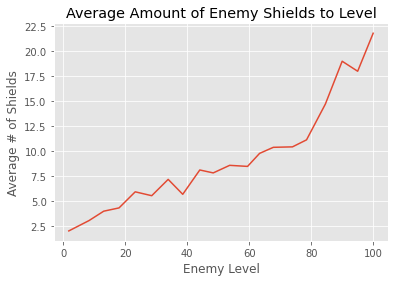

In [16]:
plt.plot(bin_df['DisplayLevel'], bin_df['Shields'])
plt.xlabel('Enemy Level')
plt.ylabel('Average # of Shields')
plt.title('Average Amount of Enemy Shields to Level')

As I thought, the amount of shields increase as the enemy levels progress. This means it takes more actions to break the enemy, and thus being able to hit weaknesses in higher level difficulty areas are more important than lower difficulty areas.

<AxesSubplot:title={'center':'Level distribition by Region'}, xlabel='Region', ylabel='DisplayLevel'>

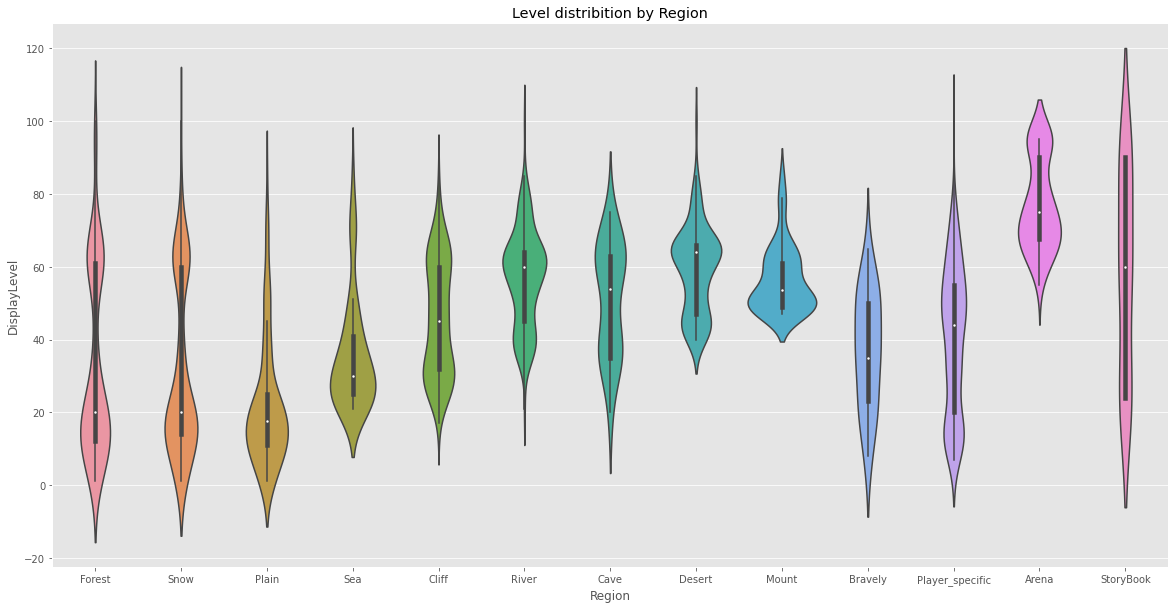

In [17]:
# graph level by region
# violin graph: x = [list of numbers for category], ...] y = [list of categories]
import seaborn as sns
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
ax.set_title('Level distribition by Region')
sns.violinplot(ax=ax, data=df[(df['Region']!='no_hit') & (df['Region']!='Foreign')], y = 'DisplayLevel', x = 'Region')

With this, we can pretty clearly see that some regions' levels are, on average, noticably larger than others. This is an intentional feature made by SquareEnix, who made the Forest/Snow/Plains as the starting zone (which the player can choose), and the next regions get progressively unlocked while scaling in difficulty. In the most recent patch, we are slowly returning to the starting regions, which is why we see a increase of levels in the Forest/Snow regions that are added. I removed the Foreign region because there's very few entries, and thus sns makes the graph look extremely bad with it included.

In [18]:
bin_df.head()

,bin,Id,DisplayLevel,Shields,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark,numWeaknesses,Forest,Snow,Plain,Sea,Cliff,River,Cave,Desert,Mount,Bravely,Foreign,Arena,beast,plant,reptile,bird,insect,human,construct,shell,fish,unholy,amphibian
0,1.0,10633.532258,1.774194,2.032258,299.483871,125.774194,125.774194,11.290323,11.838710,8.629032,72.709677,64.903226,111.870968,3.258065,49.612903,0.500000,0.612903,0.354839,0.354839,0.419355,0.483871,0.451613,0.370968,0.241935,0.306452,0.338710,0.306452,0.258065,0.258065,5.258065,0.306452,0.419355,0.274194,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.064516,0.032258,0.032258,0.064516,0.000000,0.741935,0.064516,0.000000,0.000000,0.000000,0.000000
1,2.0,5933.119565,8.293478,3.065217,777.054348,128.260870,126.565217,17.108696,18.217391,14.369565,84.391304,74.260870,123.076087,30.304348,220.315217,0.510870,0.467391,0.489130,0.380435,0.358696,0.423913,0.402174,0.347826,0.413043,0.315217,0.358696,0.260870,0.413043,0.293478,5.434783,0.347826,0.206522,0.260870,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.021739,0.0,0.0,0.282609,0.065217,0.021739,0.086957,0.021739,0.478261,0.043478,0.000000,0.000000,0.000000,0.000000
2,3.0,8276.456044,13.043956,4.005495,2180.961538,158.747253,159.280220,27.247253,20.642857,19.829670,97.153846,90.010989,128.741758,53.571429,307.670330,0.434066,0.357143,0.406593,0.384615,0.384615,0.357143,0.357143,0.335165,0.417582,0.247253,0.351648,0.269231,0.417582,0.335165,5.054945,0.236264,0.296703,0.181319,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.225275,0.043956,0.043956,0.043956,0.038462,0.434066,0.164835,0.005495,0.000000,0.000000,0.000000
3,4.0,5738.627451,17.986928,4.333333,2101.117647,183.111111,179.568627,35.679739,27.921569,25.405229,103.431373,89.359477,149.620915,96.751634,442.823529,0.398693,0.444444,0.313725,0.352941,0.385621,0.281046,0.359477,0.372549,0.405229,0.281046,0.248366,0.261438,0.379085,0.339869,4.823529,0.300654,0.372549,0.215686,0.00000,0.006536,0.000000,0.006536,0.0,0.0,0.026144,0.0,0.0,0.124183,0.045752,0.039216,0.058824,0.026144,0.450980,0.248366,0.006536,0.000000,0.000000,0.000000
4,5.0,10852.456522,23.210145,5.942029,5327.920290,248.507246,246.231884,46.239130,39.239130,36.239130,119.311594,110.347826,169.978261,230.876812,507.362319,0.369565,0.369565,0.311594,0.369565,0.376812,0.224638,0.413043,0.384058,0.398551,0.311594,0.333333,0.333333,0.253623,0.289855,4.739130,0.202899,0.253623,0.181159,0.15942,0.086957,0.007246,0.000000,0.0,0.0,0.014493,0.0,0.0,0.144928,0.021739,0.036232,0.086957,0.007246,0.434783,0.152174,0.065217,0.014493,0.014493,0.021739


Text(0, 0.5, 'Level')

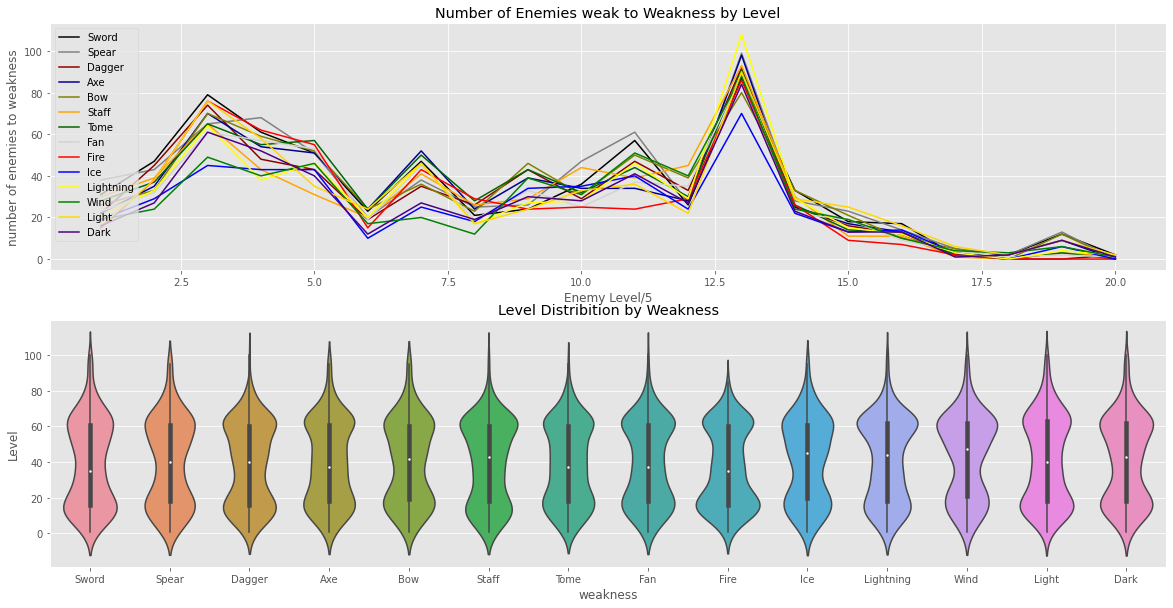

In [19]:
# weakness by level
# weakness by region
fig, ax = plt.subplots(2)
fig.set_figwidth(20)
fig.set_figheight(10)
color_code = {
    'Sword' : 'black',
    'Spear' : 'gray',
    'Dagger' : 'darkred',
    'Axe' : 'darkblue',
    'Bow': 'olive',
    'Staff' : 'orange',
    'Tome' : 'darkgreen',
    'Fan' : 'lightgrey',
    'Fire' : 'red',
    'Ice' : 'blue',
    'Lightning' : 'yellow',
    'Wind' : 'green',
    'Light' : 'gold',
    'Dark' : 'indigo'
}
def to_5_bin(level):
    return np.ceil(level/5.0)
bin_df = df.copy()
bin_df['bin'] = bin_df['DisplayLevel'].map(to_5_bin)
bin_df = bin_df.groupby(['bin'], as_index=False).sum()



for weakness in all_weaknesses:
    ax[0].plot(bin_df['bin'], bin_df['weak'+weakness], label=weakness, color = color_code[weakness])


ax[0].legend(loc='upper left')

ax[0].set_xlabel('Enemy Level/5')
ax[0].set_ylabel('number of enemies to weakness')
ax[0].set_title('Number of Enemies weak to Weakness by Level')

ax[1].set_title('Level Distribition by Weakness')
# make violin plot aggregate levels. IE: [[1,2,3,71,20], ..] ['sword']
df2 = pd.DataFrame()
df2['weakness'] = all_weaknesses
df2['list_of_levels'] = ''
df2['list_of_levels'] = df2['list_of_levels'].astype(object)
i = 0
for weakness in all_weaknesses:
    df2.at[i, 'list_of_levels'] = df[df['weak'+weakness]==1]['DisplayLevel'].tolist()
    i+=1
df2 = df2.explode('list_of_levels')
df2['list_of_levels'] = df2['list_of_levels'].astype(int)
sns.violinplot(ax = ax[1], data = df2, x = 'weakness', y = 'list_of_levels')
ax[1].set_ylabel('Level')

It appears that SquareEnix enemy designers very specifically tried to even out the weakness spread throughout the entire game. This means level is (largely) NOT a dependant trait when it comes to enemy weakness.

I will now perform weakness frequency analysis for all major regions of the map.

In [20]:
len(all_major_regions)

12

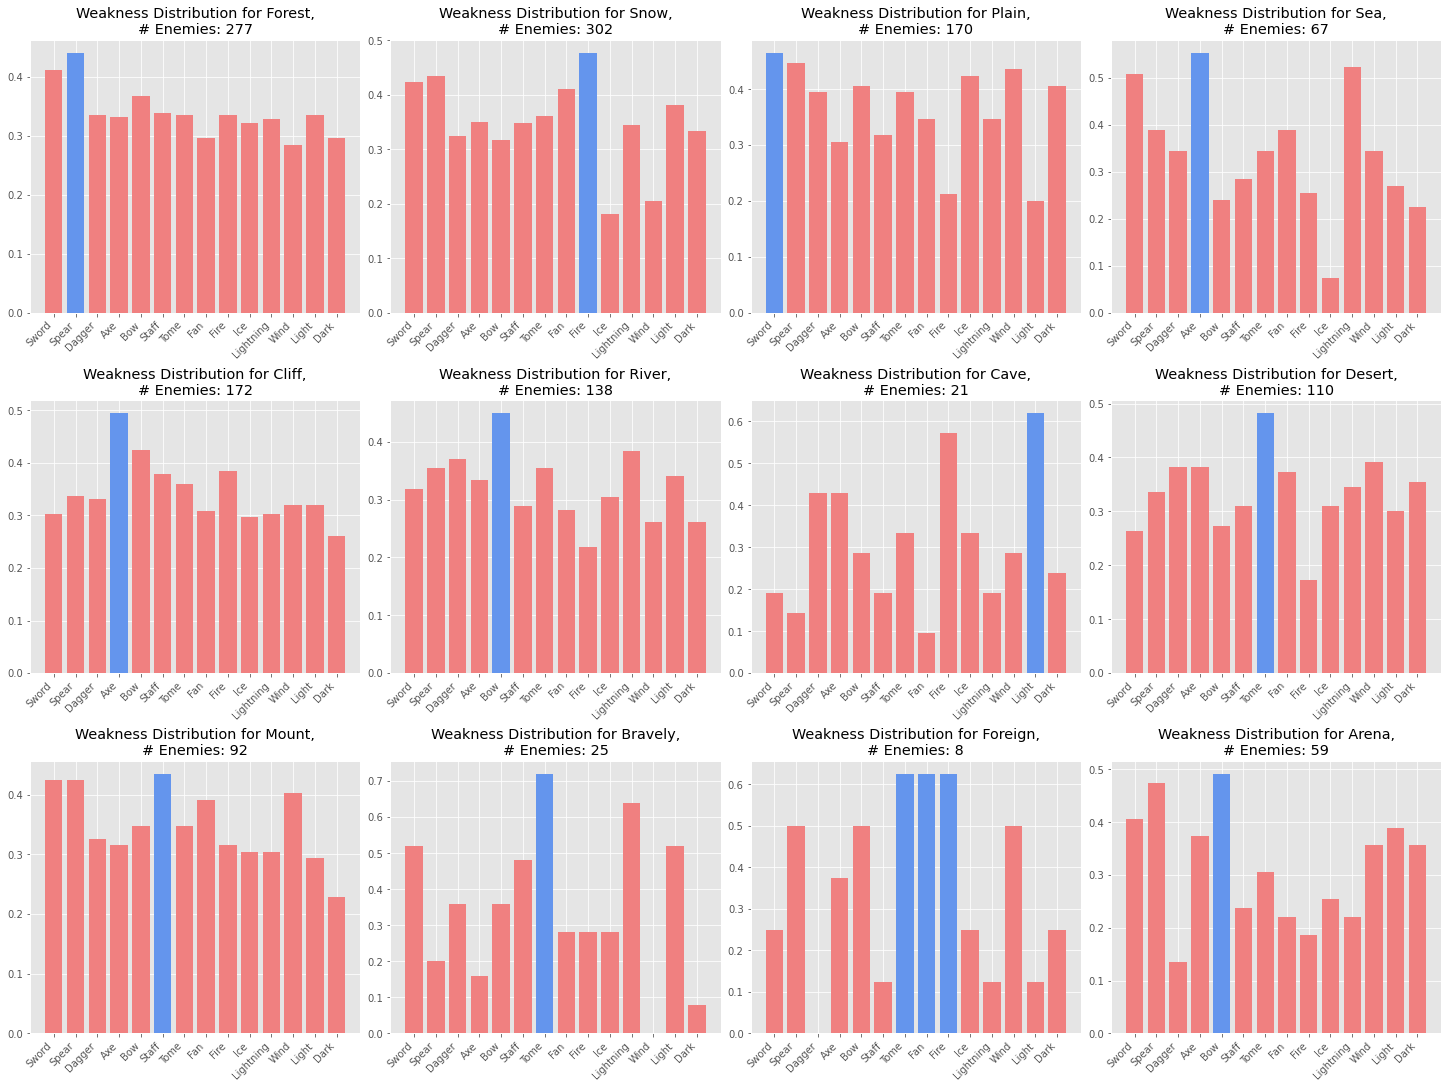

In [21]:
# do region calculation
region_df = df.copy()
fig, ax = plt.subplots(3,4,constrained_layout = True)
i = 0
fig.set_figwidth(20)
fig.set_figheight(15)
for region in all_major_regions:
    labels = []
    numbers = []
    for weakness in all_weaknesses:
        numbers.append(df[(df['Region']==region)&(df['weak'+weakness]==1)]['weak'+weakness].size)
        labels.append(weakness)
    #print(numbers)
    list_of_max = ['cornflowerblue' if x == max(numbers) else 'lightcoral' for x in numbers]
    max_size = df[df['Region']==region]['weak'+weakness].size
    ax[int(i/4)][i%4].bar(labels, [x/(max_size) for x in numbers], color=list_of_max)
    ax[int(i/4)][i%4].set_title('Weakness Distribution for '+region+f",\n# Enemies: {max_size}")
    ax[int(i/4)][i%4].set_xticklabels(labels, rotation=45, ha='right')
    
    i+=1

NOW, this seems like a significant attribute to process. As we can see, the deviations of weaknesses for each region is significantly different from one another. With this direction in mind, let's take a look at species' enemy weakness distributions.

In [22]:
print(len(df['Race'].unique()),df['Race'].unique())
all_major_races = df['Race'].unique()

11 ['beast' 'plant' 'reptile' 'bird' 'insect' 'human' 'construct' 'shell'
 'fish' 'unholy' 'amphibian']


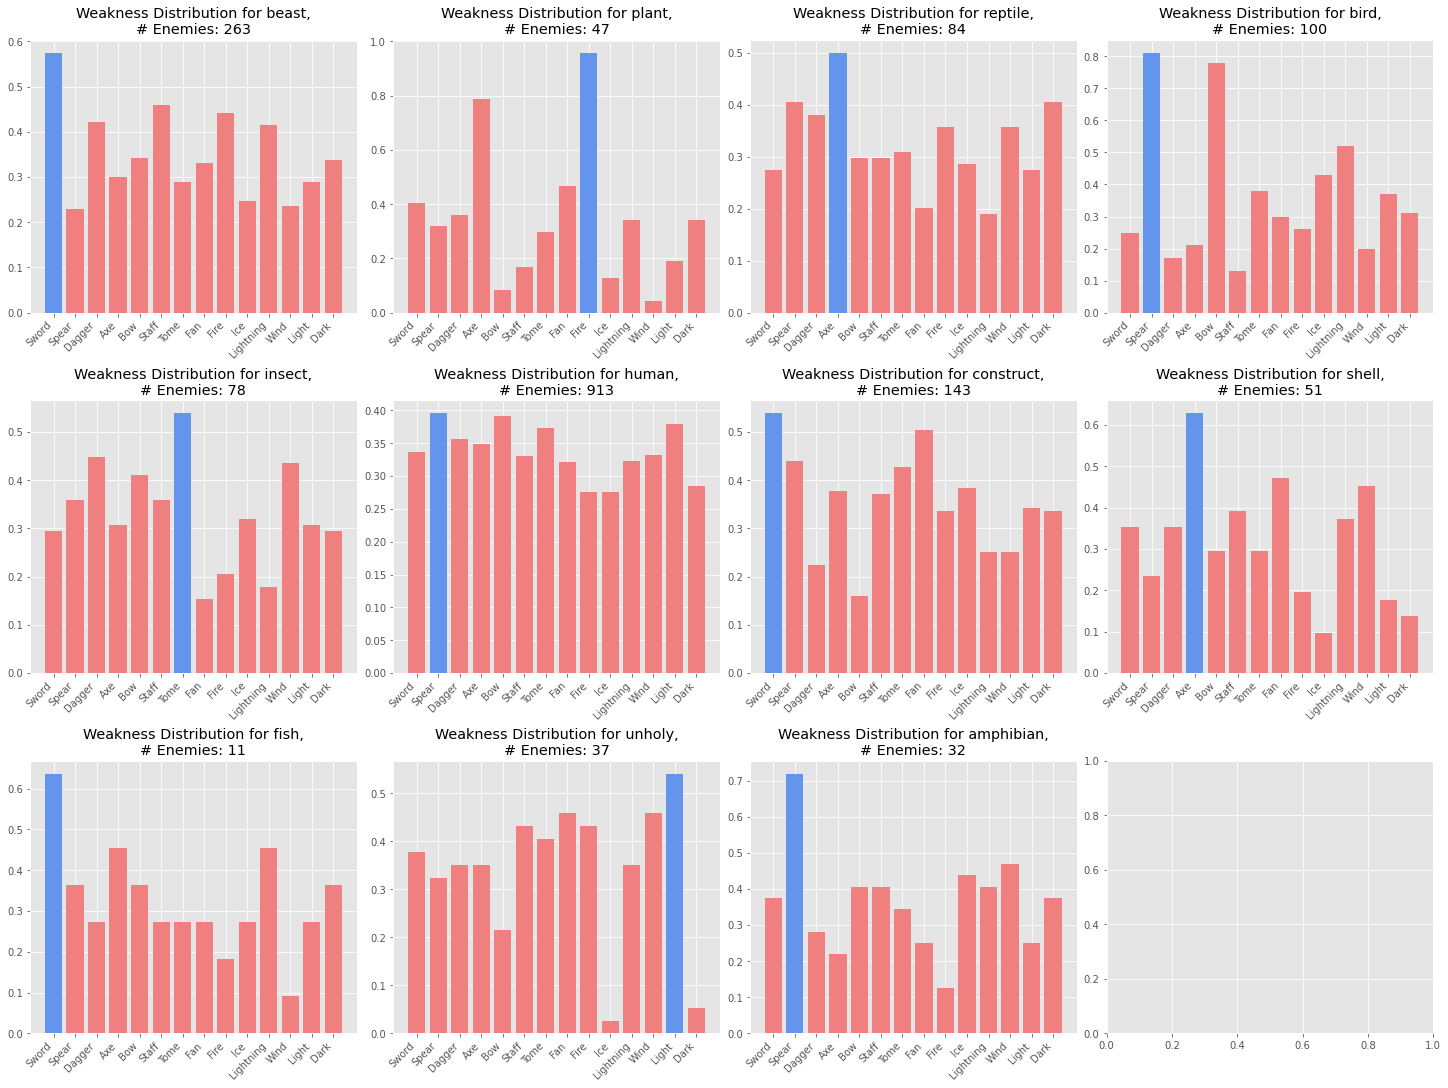

In [23]:
# do region calculation
region_df = df.copy()
fig, ax = plt.subplots(3,4,constrained_layout = True)
i = 0
fig.set_figwidth(20)
fig.set_figheight(15)
for race in all_major_races:
    labels = []
    numbers = []
    for weakness in all_weaknesses:
        numbers.append(df[(df['Race']==race)&(df['weak'+weakness]==1)]['weak'+weakness].size)
        labels.append(weakness)
    #print(numbers)
    list_of_max = ['cornflowerblue' if x == max(numbers) else 'lightcoral' for x in numbers]
    max_size = df[df['Race']==race]['weak'+weakness].size
    ax[int(i/4)][i%4].bar(labels, [x/(max_size) for x in numbers], color=list_of_max)
    ax[int(i/4)][i%4].set_title('Weakness Distribution for '+race+f",\n# Enemies: {max_size}")
    ax[int(i/4)][i%4].set_xticklabels(labels, rotation=45, ha='right')
    
    i+=1

The results of this demonstration is more significant than it may first seem. Firstly: This is just considering the species of the enemy, rather than considering the species AND the location they're present in. Generally, certain areas have specific enemy types, such as Ice-adjacent enemies in the Ice-region. Thus, a construct present in the icelands is likely to be weak to fire, as elementals are considered constructs and Ice-elementals are *always* weak to fire.

Additionally, a very large majority of enemies in this game are humans, unsurprisingly. With that in mind, SquareEnix likely made the intentional decision to assign roughly equal weaknesses to all humans.

# Part 4: Hypothesis Testing

I will make a neural network that takes in any notable features, and outputs a 12-item tuple of floats. If the float is > 0.5, that marks the prediction as 'Weak to X', whereas if the float is < 0.5, the prediction is 'Not weak to X'

Here, I will perform perhaps one of the most significant forms of analysis for my purposes: K means clustering on the weaknesses of enemies.

I will assume a default of 8 clusters, given the continent of Orsterra (the world CotC takes place in) is seperated into 8 distinct regions. If I were a developer, I would likely categorize weaknesses in that direction. However, I will still use the 'elbow method' to find the optimal amount of clusters. I'll proceed to normalize the data in order to incentivise clustering algorithms to more easily find a pattern. Conceptually, an enemy that is weak to everything should be pretty similar to an enemy who is weak to nothing.

In all honesty, if this goes too well, this might be the end of the analysis.

In [24]:
# k means
k_means_data_raw = df[['weak'+weakness for weakness in all_weaknesses]]
k_means_data = k_means_data_raw.apply(lambda x: x/sum(x), axis = 1)
k_means_data

,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark
1,0.166667,0.166667,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000
2,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.166667,0.000000,0.000000,0.166667
3,0.166667,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667
4,0.166667,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000
5,0.166667,0.166667,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
1833,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
1834,0.200000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000
1835,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000


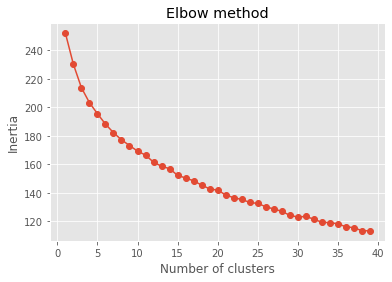

In [25]:
from sklearn.cluster import KMeans

inertias = []
max_clusters = 40

for i in range(1, max_clusters):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(k_means_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,max_clusters), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Unfortunately, this tells us that this data is very not-easy-to-cluster. Typically, using the elbow method would help find the ideal number of clusters by visualizing where the sharp drop in inertia ends. However, it seems that there is never a sharp drop in intertia past 4 clusters, despite intuitively recognising there are more than 8 clusters of enemies with grouped weaknesses. 

Similarily, I'll run a test for the maximum silhouette coefficient.

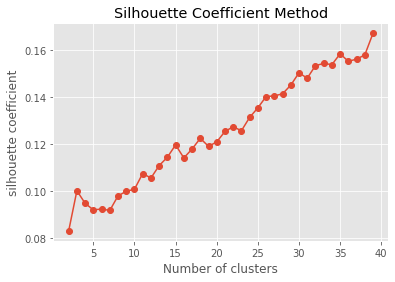

In [26]:
from sklearn.metrics import silhouette_score

silhouette_coefficients = []

for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(k_means_data)
    score = silhouette_score(k_means_data, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.plot(range(2,max_clusters), silhouette_coefficients, marker='o')
plt.title('Silhouette Coefficient Method')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette coefficient')
plt.show()

GAH. Perhaps grouping is unrealizable when the only data that is avalible to you is the enemy weaknesses. Ideally, for the silhouette coefficient method, there is a noticable peak somewhere, and increasing the number of clusters result in worse coefficients. Since the coefficient is intent on rising, however, that would mean there is no optimal number of clusters within 40 clusters, which is unideal to say the least.

Regardless, I will assign each enemy with their supposed 'group' with the number of clusters being 15, as that's the closest to being an ideal peak as I could see.

In [27]:
kmeans = KMeans(n_clusters=15)
kmeans.fit(k_means_data)
df['group'] = kmeans.labels_

In [28]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

For entirely my own sake, I will look at each cluster and find any intuitive correlations.

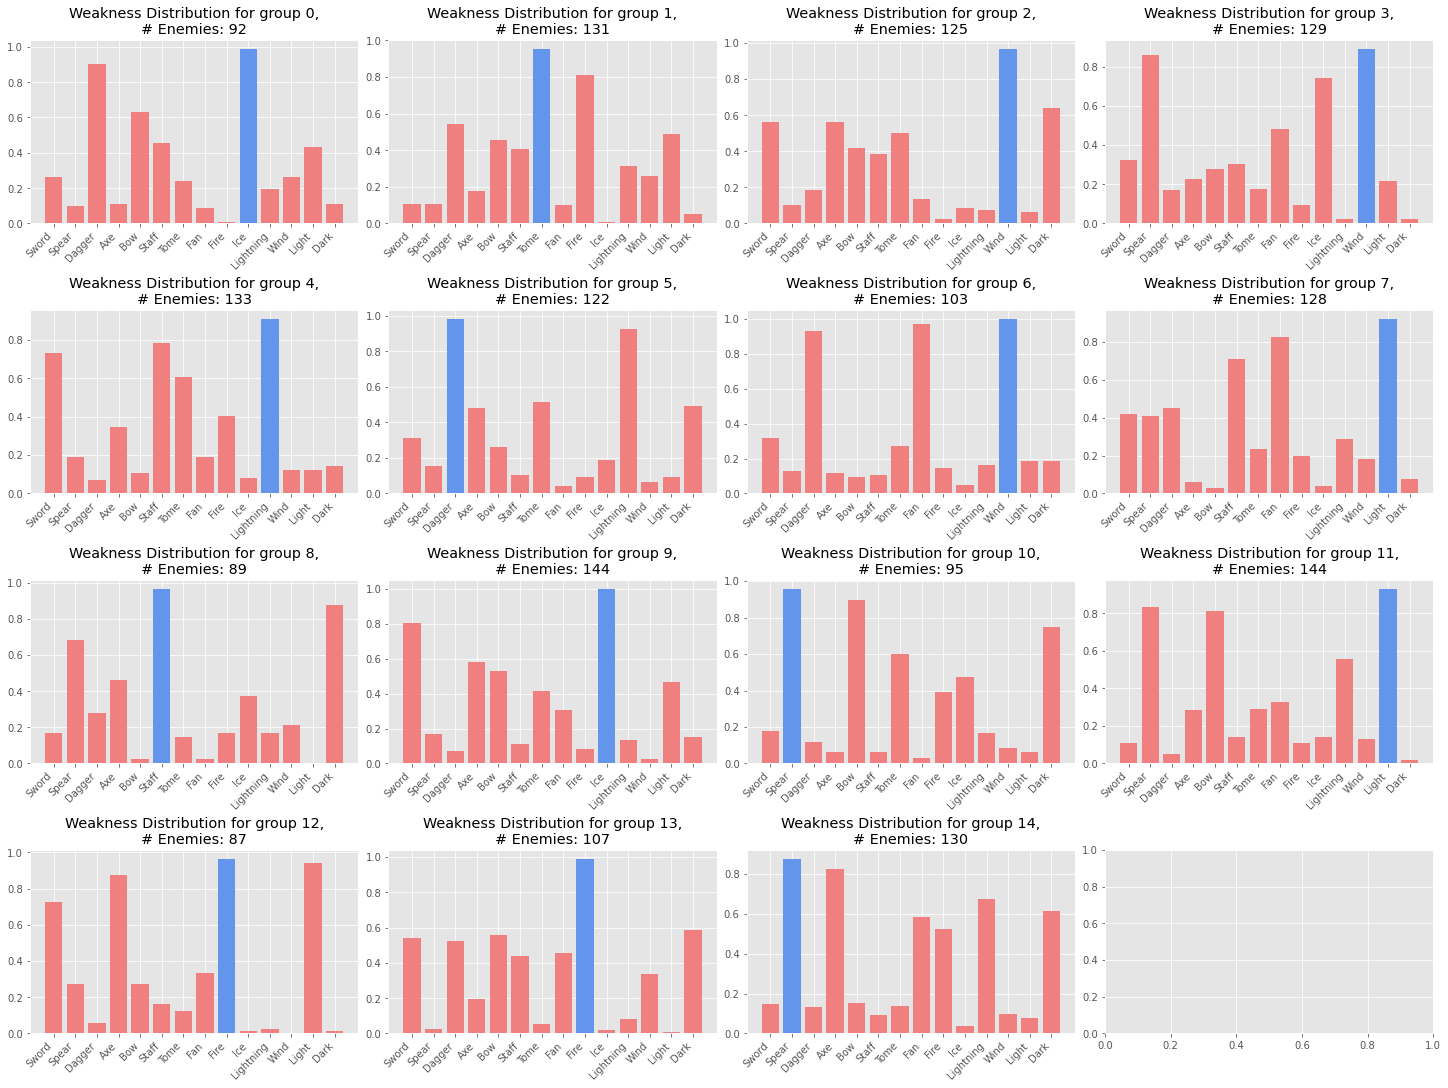

In [29]:
# do region calculation
group_df = df.copy()
fig, ax = plt.subplots(4,4,constrained_layout = True)
i = 0
fig.set_figwidth(20)
fig.set_figheight(15)
for i in range(0,15):
    labels = []
    numbers = []
    for weakness in all_weaknesses:
        numbers.append(df[(df['group']==i)&(df['weak'+weakness]==1)]['weak'+weakness].size)
        labels.append(weakness)
    #print(numbers)
    list_of_max = ['cornflowerblue' if x == max(numbers) else 'lightcoral' for x in numbers]
    max_size = df[df['group']==i]['weak'+weakness].size
    ax[int(i/4)][i%4].bar(labels, [x/(max_size) for x in numbers], color=list_of_max)
    ax[int(i/4)][i%4].set_title('Weakness Distribution for group '+str(i)+f",\n# Enemies: {max_size}")
    ax[int(i/4)][i%4].set_xticklabels(labels, rotation=45, ha='right')
    
    i+=1

In [30]:
for i in range(0,15):
    print(f'Set of enemies in group {i}:')
    print(set(df[df['group']==i]['Name']))

Set of enemies in group 0:
{'Vicious Shadow Wisp', 'Old Man', 'Mighty Blood Viper', 'Master of All', 'Man', 'Menacing Killer Chameleon', 'Otherworld Collared Salamander', 'Elderly Woman', 'Wicked Flatlands Frogking III', 'Vicious Sand Lizardman III', 'Vicious Giant Slug', 'Eggling', 'Mountain Goat', 'Cave Beast', 'Edoras Soldier I', 'Vicious Sand Lizardking III', 'Light Wisp', 'Gonzalez the Ironarm', 'Vicious Gooey Slug', 'Shadow Wisp', 'Blackrobe (Bow)', 'Blue', 'Slayer Bug', 'Flatlands Froggen', 'Savage Killer Chameleon', 'Blood Viper', 'Edoras Soldier', 'Blood Remnant', 'Tyrannodrake', 'Otherworld Flatlands Frogking II', 'Savage Blazing Remnant Mk.II', 'Savage Bloody Bull', 'Sentry', 'Wily Gigantes', 'Mighty Edoras Soldier', 'Youth', 'Mercenary', 'Pardis the Scholarking', 'Sangre', 'Savage Admiral', 'Admiral', 'Collared Salamander', 'Menacing Senior Fellow I', 'Merchant', 'Mottled Asp', 'Cliff Birdkin III', 'Tavern Maid', 'Soldier', 'Suspicious Man', 'Thief', 'Abnormal Ruffian', "De

As we can see, the K-means clustering actually works to some extent! While I cannot visualize the name of all groups' names in a reasonable way, I will say that some groups appear to have some intuitive correlation (either region or species of the enemy are similar), while other groups do not.

Now, moving on to prediciton given species, level, and region.

## Neural network implementation method

In [31]:
df.head(1)
# level, shields, number of weaknesses, region(12), Race (11)

,Id,Label,Name,DisplayLevel,Shields,StartingWeaknesses,HP,PAtk,MAtk,EquipAtk,PDef,MDef,Speed,Crit,CritDef,Exp,Money,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark,numWeaknesses,Region,Forest,Snow,Plain,Sea,Cliff,River,Cave,Desert,Mount,Bravely,Foreign,Arena,Race,beast,plant,reptile,bird,insect,human,construct,shell,fish,unholy,amphibian,group
1,1,Forest_Enemy_01a_001,Marmot,1.0,2,"[Sword, Spear, Dagger, Staff, Fire, Light]",91,99,99,10,10,7,69,56,110,4,19,1,1,1,0,0,1,0,0,1,0,0,0,1,0,6,Forest,1,0,0,0,0,0,0,0,0,0,0,0,beast,1,0,0,0,0,0,0,0,0,0,0,7


In [32]:
X = df[['DisplayLevel','Shields', 'numWeaknesses', 'Forest','Snow','Plain','Sea','Cliff','River','Cave','Desert','Mount','Bravely','Foreign','Arena','beast','plant','reptile','bird','insect','human','construct','shell','fish','unholy','amphibian']]
print(X.shape)
y = df[['weak'+weakness for weakness in all_weaknesses]]
print(y.shape)

(1759, 26)
(1759, 14)


In [33]:
# neural network
import keras

import keras.layers as layers
from keras.models import Model
from keras.layers import Input, Dense

input = Input(shape=(26,),name='input_layer')
x = layers.Dense(32, name='dense_1')(input)
outputs = layers.Dense(14, name = 'predictions')(x)

model = Model(inputs = input, outputs = outputs)

model.compile(loss = 'binary_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 26)]              0         
                                                                 
 dense_1 (Dense)             (None, 32)                864       
                                                                 
 predictions (Dense)         (None, 14)                462       
                                                                 
Total params: 1,326
Trainable params: 1,326
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(X,y,epochs=10,verbose=1)

Epoch 1/10
50/50 [==============================] - 0s 3ms/step - loss: 6.0485
Epoch 2/10
50/50 [==============================] - 0s 3ms/step - loss: 6.0414
Epoch 3/10
50/50 [==============================] - 0s 4ms/step - loss: 6.0221
Epoch 4/10
50/50 [==============================] - 0s 3ms/step - loss: 6.0129
Epoch 5/10
50/50 [==============================] - 0s 3ms/step - loss: 5.9990
Epoch 6/10
50/50 [==============================] - 0s 3ms/step - loss: 5.9486
Epoch 7/10
50/50 [==============================] - 0s 3ms/step - loss: 5.8570
Epoch 8/10
50/50 [==============================] - 0s 3ms/step - loss: 5.5238
Epoch 9/10
50/50 [==============================] - 0s 3ms/step - loss: 5.4431
Epoch 10/10
50/50 [==============================] - 0s 3ms/step - loss: 5.4511


The loss here is considerably higher than I am comforatable with, but I unfortunately don't know what to do to lower it, unfortunately. 

Let's take the first enemy on the datatable and try and predict its weaknesses!

In [35]:
X[:1]

,DisplayLevel,Shields,numWeaknesses,Forest,Snow,Plain,Sea,Cliff,River,Cave,Desert,Mount,Bravely,Foreign,Arena,beast,plant,reptile,bird,insect,human,construct,shell,fish,unholy,amphibian
1,1.0,2,6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [45]:
result = model.predict(X[:1])
result

1/1 [==============================] - 0s 14ms/step


array([[ 0.75623363,  0.5997299 ,  1.0941399 ,  0.55391514,  0.8760331 ,
         0.27224627, -3.6384146 , -1.1772012 , -0.5236785 , -2.7371454 ,
        -0.13277057,  1.2228211 ,  1.0179228 ,  1.1749166 ]],
      dtype=float32)

The following table is the prediction resulting from the neural network:

In [46]:
display_df = pd.DataFrame(columns=y.columns)
display_df.loc[1] = result.flatten()
display_df.applymap(lambda x: 1 if x > 0.5 else 0)

,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark
1,1,1,1,1,1,0,0,0,0,0,0,1,1,1


The following table is the true weakness spread from the data table.

In [47]:
y[:1]

,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark
1,1,1,1,0,0,1,0,0,1,0,0,0,1,0


As seen, the prediction successfully predicted several correct weaknesses, but also misses other weaknesses. Sometimes it predicts a weakness that isn't always present. Let's do a dataframe-wide prediction to see how many 'on-weaknesses' there are on average, and how many off-weaknesses there are on average.

In [48]:
result = model.predict(X)

55/55 [==============================] - 0s 1ms/step


In [92]:
display_df = pd.DataFrame()
display_df[y.columns] = result.tolist()
compare_df = display_df.copy()
display_df = display_df.applymap(lambda x: 1 if x > 0.5 else 0)
display_df = display_df - y.reset_index(drop=True)
or_df = display_df.applymap(lambda x: 1 if x!=0 else 0) | (y.reset_index(drop=True))

In [93]:
def add_pos(x, onlyPositive):
    i=0
    for ele in x:
        if onlyPositive and ele > 0:
            i+=1
        elif not onlyPositive and ele < 0:
            i+=1
    return i
def count_zero(x):
    i=0
    for ele in x:
        if ele == 0:
            i+=1
    return i


compare_df['false_positive'] = display_df.apply(lambda x: add_pos(x, True),axis=1)
compare_df['true_negative'] = or_df.apply(lambda x: count_zero(x),axis=1)
compare_df['true_positive'] = display_df.apply(lambda x: count_zero(x),axis=1) - compare_df['true_negative']
compare_df['false_negative'] = display_df.apply(lambda x: add_pos(x, False),axis=1)
compare_df

,weakSword,weakSpear,weakDagger,weakAxe,weakBow,weakStaff,weakTome,weakFan,weakFire,weakIce,weakLightning,weakWind,weakLight,weakDark,false_positive,true_negative,true_positive,false_negative
0,0.756234,0.599730,1.094140,0.553915,0.876033,0.272246,-3.638415,-1.177201,-0.523679,-2.737145,-0.132771,1.222821,1.017923,1.174917,4,4,4,2
1,0.897695,0.939162,0.765184,0.663821,0.686530,-0.030258,-3.597452,-1.064805,-0.982501,-2.696862,0.316519,1.109060,1.216291,1.020575,5,3,3,3
2,1.089098,0.199543,0.642201,0.359549,0.816092,0.728628,-3.972241,-1.254625,-1.167524,-2.965449,0.500477,1.449480,0.657317,1.142102,3,5,5,1
3,1.063631,1.001484,0.086463,0.246034,1.320323,0.588986,-4.070745,-0.933986,-1.122534,-2.675141,0.722659,1.612221,0.384781,1.301544,3,5,4,2
4,0.756234,0.599730,1.094140,0.553915,0.876033,0.272246,-3.638415,-1.177201,-0.523679,-2.737145,-0.132771,1.222821,1.017923,1.174917,4,4,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,-0.573011,11.507611,-6.841863,-1.392941,-2.813838,-6.960126,-14.395452,-5.445074,-3.908064,-17.408194,-3.433232,6.133749,-4.535151,-8.919954,1,10,1,2
1755,-0.718564,16.826921,-10.264872,-2.324412,-4.281147,-10.222561,-19.719912,-7.074132,-5.194228,-24.080238,-5.175007,9.320775,-7.649682,-14.118227,1,11,1,1
1756,-1.186468,5.901400,-3.200934,-0.253544,-1.238415,-4.096198,-9.509298,-4.521014,-3.317799,-11.993242,-1.961547,0.721033,-0.308189,-1.913238,0,9,2,3
1757,-1.186349,11.970556,-7.257038,-1.426537,-3.002057,-7.684272,-15.065207,-6.000284,-4.493914,-18.867086,-3.865973,5.033391,-4.347299,-8.566753,1,10,1,2


In [123]:
totone = 0
totzero = 0
for weakness in all_weaknesses:
    totzero+=y['weak'+weakness].value_counts()[0]
    totone +=y['weak'+weakness].value_counts()[1]

In [124]:
print(f"Tot number of weaknesses: {totone}")
print(f"Tot number of non-weaknesses: {totzero}")
print(f"Tot number of True-Positive guesses: {compare_df['true_positive'].sum()}")
print(f"Tot number of True-Negative guesses: {compare_df['true_negative'].sum()}")
print(f"Tot number of False-Positive guesses: {compare_df['false_positive'].sum()}")
print(f"Tot number of False-Negative guesses: {compare_df['false_negative'].sum()}")

Tot number of weaknesses: 8414
Tot number of non-weaknesses: 16212
Tot number of True-Positive guesses: 1654
Tot number of True-Negative guesses: 13348
Tot number of False-Positive guesses: 2864
Tot number of False-Negative guesses: 6760


Well, it seems that this neural network is decently good at predicting if things are not a weakness, but not so much if something is a weakness. Distribution wise, if it predicts something is a weakness, there's really a `1654/8414 = 0.20 = 20%` chance that it gets it right. However, it has a much higher accuracy of predicting when things aren't a weakness: If the model predicts that something is NOT a weakness, then there's a `13348/16212 = 0.82 = 82%` chance of it being correct!

## Decision tree implementation method

It appears that the model guesses correctly, on average, a single weakness, but removes around 7.5 weaknesses from consideration on average. In other words: Whatever the model does not guess is likely not to show up on the enemy weaknesses. Unfortunately, there are a significant amount of false positives and false negatives.

Here, I will create 14 decision trees, each with a depth of 4, in order to see if this is a better way to go about predicting weaknesses.

In [127]:
from sklearn import tree
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
print(X.shape)
print(y.shape)

(1759, 26)
(1759, 14)


In [222]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=10)

name_list = []
clfs_of_weaknesses = []
score_list_conf_matri = []
score_list_conf_matri_t = []
accuracy = []
accuracy_t = []

for (columnName, columnData) in y_train.iteritems():
    clf = tree.DecisionTreeClassifier(max_depth=X.shape[1])
    clf.fit(X_train, columnData)
    pred = clf.predict(X_train)

    name_list.append(columnName)
    clfs_of_weaknesses.append(clf)
    accuracy.append(accuracy_score(columnData,pred))

i = 0
for (columnName,columnData) in y_test.iteritems():
    clf = clfs_of_weaknesses[i]
    pred = clf.predict(X_test)
    accuracy_t.append(accuracy_score(columnData, pred))
    score_list_conf_matri_t.append(confusion_matrix(columnData, pred))
    i+=1

print(f"Mean train accuracy: {np.array(accuracy).mean()}")
print(f"Mean test accuracy: {np.array(accuracy_t).mean()}")
i=0
for (columnName,columnData) in y.iteritems():
    clf = clfs_of_weaknesses[i]
    pred = clf.predict(X)
    confm = confusion_matrix(columnData, pred)
    score_list_conf_matri.append(confm)
    i+=1

Mean train accuracy: 0.9186335403726708
Mean test accuracy: 0.7294372294372294


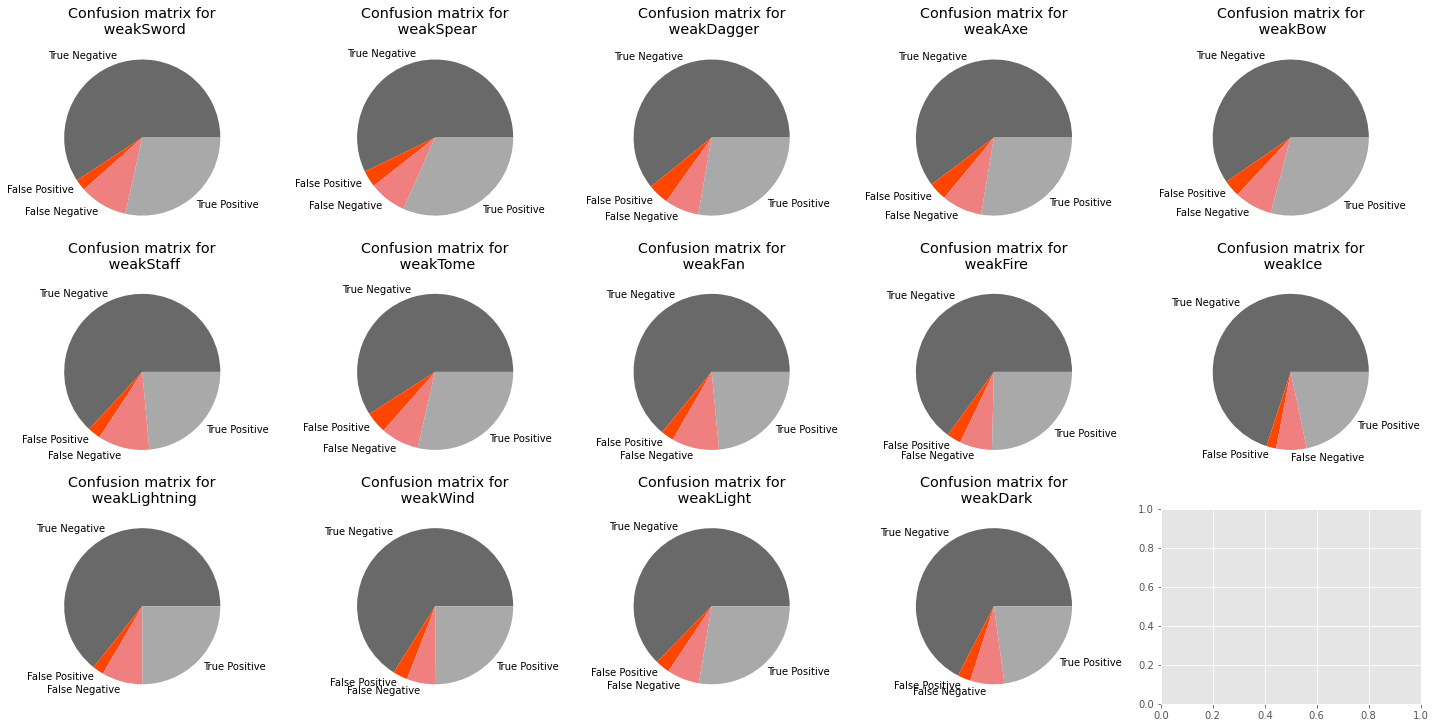

In [223]:
fig, ax = plt.subplots(3,5,constrained_layout = True)
fig.set_figheight(10)
fig.set_figwidth(20)
i=0
for score in score_list_conf_matri: 
    ax[int(i/5)][i%5].pie(score.flatten(), labels=['True Negative', 'False Positive','False Negative', 'True Positive'], colors=['dimgray','orangered','lightcoral','darkgray'])
    ax[int(i/5)][i%5].set_title(f'Confusion matrix for\n {name_list[i]}')
    i+=1

In [224]:
print(score_list_conf_matri[0])
print(f"This is true negative (0 true, 0 predict): {score_list_conf_matri[0][0][0]}")
print(f"This is false positive (0 true, 1 predict): {score_list_conf_matri[0][0][1]}")
print(f"This is false negative (1 true, 0 predict): {score_list_conf_matri[0][1][0]}")
print(f"This is true positive (1 true, 1 predict): {score_list_conf_matri[0][1][1]}")

[[1042   41]
 [ 175  501]]
This is true negative (0 true, 0 predict): 1042
This is false positive (0 true, 1 predict): 41
This is false negative (1 true, 0 predict): 175
This is true positive (1 true, 1 predict): 501


In [226]:
tp = 0
fp = 0
fn = 0
tn = 0
for score in score_list_conf_matri:
    tn += score[0][0]
    fp += score[0][1]
    fn += score[1][0]
    tp += score[1][1]
print(f"Tot number of weakness cases: {tp+fn}")
print(f"Tot number of no-weakness cases: {tn+fp}")
print("Decision tree results:")
print(f"Tot number of True-Positive guesses: {tp}")
print(f"Tot number of True-Negative guesses: {tn}")
print(f"Tot number of False-Positive guesses: {fp}")
print(f"Tot number of False-Negative guesses: {fn}")

Tot number of weakness cases: 8414
Tot number of no-weakness cases: 16212
Decision tree results:
Tot number of True-Positive guesses: 6467
Tot number of True-Negative guesses: 15456
Tot number of False-Positive guesses: 756
Tot number of False-Negative guesses: 1947


Result of Neural Network:

`Tot number of True-Positive guesses: 1654`

`Tot number of True-Negative guesses: 13348`

`Tot number of False-Positive guesses: 2864`

`Tot number of False-Negative guesses: 6760`

To review: If the decision tree predicted a weakness, there is a `6467/8414=0.77=77%` chance of it being accurate. If the decision tree predicted that there is no weakness, there is a `15456/16212=0.95=95%` chance that it is accurate.

The relative accuracies are noticably lower in the test bin compared to the training bin, suggesting overfitting. However, I have noticed that increasing the maximum number of layers only presents a benefit to the test bin, up to a maximum depth of 40 layers.

In hindsight, it might've been more productive to simply create 14 decision trees. Not only does each tree only need to focus on one weakness, thus not being interfered with other correlating values, but each weakness doesn't need to share logic nodes with other weaknesses. I would like to emphasize: With proper research in how to optimize for binary crossentropy, I believe a neural network can perform just as well.

# Part 5: Conclusions and Insights

To conclude, I would like preface that the pragmatic value of this experiment is bordering on non-existent. It is a project meant to explore the psyche of SquareEnix designers, and one that serves little pragmatic purpose towards the user. Afterall, all the weaknesses can be already datamined, there are certain characters that can reveal weaknesses, and there are video tutorials for every major difficult boss you can think of. The most practical purpose this project can serve is to aid with the creation of filler mobs without hiring brainpower to think of weaknesses that would fit the mob's design.

With that said, if I had more time, I would introduce more than a variety of changes. Particularly, I would instead group each monster by their presenting attributes instead of their species. This is because: Species are ambiguous. An iron golem would be considered a 'construct' and so would a ice elemental. While it's technically not incorrect, it's not sufficient information to discern the difference. However, if I had attributes such as "Is flying" and "Is elemental construct", one could be seperated from the other. Due to time constraints, however, I am unfortunately unable to fulfill that.

A valuable point of information is: Square Enix genuinely wants to even the weakness spread such that one damage type isn't dominant over the other. As such, we can predict the next major region to have different weakness spreads than a previously released region, just with the information present in the exploratory data analysis.

Additionally, trying to group enemies by their respective weaknesses would be fruitless. Through the K-means clustering results, similar weaknesses do not imply same origins. However, the inverse is not necessarily untrue, as is proven by the decision tree analysis.

Additionally, something I haven't considered is the fact that certain weaknesses appear to be somewhat dependant on other weaknesses. For example, unholy enemies that are NOT weak to wind are all weak to light. This information has not been represented in any way, and is sufficiently significant in gameplay such that I hoped to touch upon it. A PCA of the weakness spread of enemies may aid in this discovery, but due to time constraits I haven't the time to try it myself.

# Part 6: Bloopers

I have spent approximately 12 hours creating a functioning parser for the datamined data table before I informed an Octopath dataminer that their tables were outdated. Soon after, said Octopath dataminer uploaded the newest version's datamined enemies.

I have spent over 20 hours attempting to datamine the game, as there is a sincere lack of resources avalible to the public on cracking android app data. I have not yet succeeded in this endeavor.

I have spend several hours attempting to find the approximate Z-score of each enemy's difficulty as I thought it was significant in determining which damage type was most used by significant enemies, only to realize the implications of this would be far, FAR beyond the scope of this project. To elaborate: This would make this analysis become "Predicting the value of a damage type" rather than "predicting the weaknesses of enemies given their attributes."

Lastly, playing this game was the biggest blooper of all. I do not recommend it.

![play time](IMG_1993.PNG)
